# CLAHE Tutorial with NVIDIA DALI
Welcome to this hands-on tutorial!
In this notebook, you'll learn how to use Contrast Limited Adaptive Histogram Equalization (CLAHE) with NVIDIA DALI for image enhancement.

# Introduction to CLAHE
This notebook demonstrates how to use **CLAHE (Contrast Limited Adaptive Histogram Equalization)** in a DALI pipeline for image preprocessing.

CLAHE is a powerful technique that improves contrast in images without overamplifying noise, making it particularly useful for medical imaging, surveillance, and low-contrast photography.

## Using Real Medical Imaging Data
This tutorial includes demonstrations with **real knee MRI slices** from the DALI_extra repository, which perfectly showcase CLAHE's effectiveness on low-contrast medical images.

**To use the MRI data:**
```bash
# Clone DALI_extra (requires git-lfs)
git clone https://github.com/NVIDIA/DALI_extra.git
cd DALI_extra && git lfs pull

# Set environment variable
export DALI_EXTRA_PATH=/path/to/DALI_extra
```

The MRI data will be at: `$DALI_EXTRA_PATH/db/3D/MRI/Knee/npy_2d_slices/STU00001/SER00001/`

The data is organized in a nested structure:
- `STU00001/` - Patient study directory
- `SER00001/`, `SER00002/`, ... - Series directories (different MRI sequences)
- `0.npy`, `1.npy`, ... - Individual 2D slice files

---

## Required Imports
Let's start by importing the necessary DALI modules and NumPy for data analysis.


In [1]:
import nvidia.dali as dali
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import numpy as np

## Building the CLAHE Pipeline
The main pipeline function creates a DALI processing pipeline that applies CLAHE enhancement to images. This pipeline can work with either real images from a directory or synthetic test data.

**Key CLAHE Parameters:**
- `tiles_x`, `tiles_y`: Grid size for local processing (higher = more local adaptation)
- `clip_limit`: Threshold to prevent noise amplification (higher = more contrast)
- `luma_only`: For RGB images - **True** (default) processes only luminance (LAB L* channel), preserving color balance. **GPU only supports luma_only=True**. Set to False for per-channel RGB processing (CPU only).

> **Try it yourself:** Review the function below and see how you can adjust the parameters for your own images.

In [2]:
def create_clahe_pipeline(
    batch_size=4, num_threads=2, device_id=0, image_dir=None
):
    """
    Create a DALI pipeline with CLAHE operator.

    Args:
        batch_size (int): Number of images per batch
        num_threads (int): Number of worker threads
        device_id (int): GPU device ID
        image_dir (str): Directory containing images (if None, uses synthetic data)

    Returns:
        DALI pipeline with CLAHE preprocessing
    """

    @dali.pipeline_def(
        batch_size=batch_size, num_threads=num_threads, device_id=device_id
    )
    def clahe_preprocessing_pipeline():
        if image_dir:
            # Read images from directory
            images, labels = fn.readers.file(
                file_root=image_dir, random_shuffle=True
            )
            images = fn.decoders.image(images, device="mixed")  # Decode on GPU

            # Resize to consistent size
            images = fn.resize(images, size=[256, 256])
        else:
            # Create synthetic test images with varying contrast
            # This simulates real-world scenarios where CLAHE is beneficial

            # Generate base image with moderate values to avoid overflow
            images = fn.random.uniform(
                range=(60, 180), shape=(256, 256, 3), dtype=types.FLOAT
            )

            # Add some contrast variation to make CLAHE effect visible
            contrast_factor = fn.random.uniform(range=(0.5, 0.9))
            images = images * contrast_factor

            # Add small brightness variation (keeping within safe range)
            brightness_offset = fn.random.uniform(range=(-20, 20))
            images = images + brightness_offset

            # Convert to uint8 (DALI will automatically clamp to [0,255])
            images = fn.cast(images, dtype=types.UINT8)

        # Apply CLAHE for adaptive histogram equalization
        # This is where the magic happens!
        # Note: GPU only supports luma_only=True (default)
        clahe_images = fn.clahe(
            images,
            tiles_x=8,  # 8x8 grid of tiles for local processing
            tiles_y=8,
            clip_limit=2.0,  # Moderate clipping to prevent noise
            luma_only=True,  # Default: process luminance in LAB space (GPU-supported)
        )

        return images, clahe_images

    return clahe_preprocessing_pipeline()

## Parameter Comparison Function
Let's create a function to demonstrate how different CLAHE parameters affect the results.

> **Try it yourself:** Experiment with different values for `tiles_x`, `tiles_y`, and `clip_limit` to see their impact.

In [3]:
def demonstrate_clahe_parameters():
    """
    Demonstrate different CLAHE parameter settings to show their effects.

    Returns:
        DALI pipeline that generates one base image and three CLAHE variants
    """

    @dali.pipeline_def(batch_size=1, num_threads=1, device_id=0)
    def parameter_demo_pipeline():
        # Create a test image with poor contrast (narrow intensity range)
        base_image = fn.random.uniform(
            range=(80, 120), shape=(256, 256, 1), dtype=types.UINT8
        )

        # Different CLAHE configurations to compare:

        # 1. Default settings - balanced approach
        clahe_default = fn.clahe(
            base_image,
            tiles_x=8,
            tiles_y=8,  # Standard 8x8 grid
            clip_limit=2.0,  # Moderate contrast limiting
        )

        # 2. Aggressive enhancement - more contrast, more local adaptation
        clahe_aggressive = fn.clahe(
            base_image,
            tiles_x=16,
            tiles_y=16,  # Finer 16x16 grid
            clip_limit=4.0,  # Higher contrast limit
        )

        # 3. Gentle enhancement - subtle improvement
        clahe_gentle = fn.clahe(
            base_image,
            tiles_x=4,
            tiles_y=4,  # Coarser 4x4 grid
            clip_limit=1.0,  # Conservative contrast limit
        )

        return base_image, clahe_default, clahe_aggressive, clahe_gentle

    return parameter_demo_pipeline()

## Running the CLAHE Pipeline
Now let's execute our pipeline and see CLAHE in action! We'll analyze the results and measure the contrast improvement.

> **Try it yourself:** Run the next cell and observe the printed analysis for each image.

In [4]:
# Create and build pipeline
print("Creating CLAHE pipeline...")
pipe = create_clahe_pipeline(batch_size=2, num_threads=1, device_id=0)
pipe.build()
print("Pipeline built successfully")

# Run pipeline
print("\nRunning pipeline...")
outputs = pipe.run()
original_images, clahe_images = outputs

# Move to CPU for analysis
original_batch = original_images.as_cpu()
clahe_batch = clahe_images.as_cpu()

print(f"Processed {len(original_batch)} images")

# Analyze results
print("\n" + "=" * 50)
print("CLAHE RESULTS ANALYSIS")
print("=" * 50)

for i in range(len(original_batch)):
    original = np.array(original_batch[i])
    enhanced = np.array(clahe_batch[i])

    print(f"\n  Image {i + 1}:")
    print(
        f"  Original  - Shape: {original.shape}, Range: [{original.min():.1f}, {original.max():.1f}]"
    )
    print(
        f"  Enhanced  - Shape: {enhanced.shape}, Range: [{enhanced.min():.1f}, {enhanced.max():.1f}]"
    )

    # Calculate contrast metrics (standard deviation as a proxy for contrast)
    orig_std = np.std(original)
    enhanced_std = np.std(enhanced)
    contrast_improvement = enhanced_std / orig_std if orig_std > 0 else 1.0

    print(f"  Contrast improvement: {contrast_improvement:.2f}x")

print("\nCLAHE pipeline executed successfully!")

Creating CLAHE pipeline...
Pipeline built successfully

Running pipeline...
Processed 2 images

CLAHE RESULTS ANALYSIS

  Image 1:
  Original  - Shape: (256, 256, 3), Range: [21.0, 86.0]
  Enhanced  - Shape: (256, 256, 3), Range: [9.0, 168.0]
  Contrast improvement: 1.91x

  Image 2:
  Original  - Shape: (256, 256, 3), Range: [68.0, 167.0]
  Enhanced  - Shape: (256, 256, 3), Range: [2.0, 240.0]
  Contrast improvement: 1.75x

CLAHE pipeline executed successfully!
Processed 2 images

CLAHE RESULTS ANALYSIS

  Image 1:
  Original  - Shape: (256, 256, 3), Range: [21.0, 86.0]
  Enhanced  - Shape: (256, 256, 3), Range: [9.0, 168.0]
  Contrast improvement: 1.91x

  Image 2:
  Original  - Shape: (256, 256, 3), Range: [68.0, 167.0]
  Enhanced  - Shape: (256, 256, 3), Range: [2.0, 240.0]
  Contrast improvement: 1.75x

CLAHE pipeline executed successfully!


[/opt/dali/dali/operators/image/clahe/clahe_cpu.cc:77] CRITICAL: CLAHE expects RGB channel order (Red, Green, Blue). If your images are in BGR order (common with OpenCV cv2.imread), the luminance calculation will be INCORRECT. Convert BGR to RGB using fn.reinterpret or similar operators before CLAHE.


## Parameter Comparison Experiment
Let's compare different CLAHE parameter settings to understand their effects on image enhancement.

> **Try it yourself:** Run the cell below and compare the standard deviation values for each configuration.

In [5]:
# Demonstrate parameter variations
print("Testing different CLAHE parameters...")
param_pipe = demonstrate_clahe_parameters()
param_pipe.build()

param_outputs = param_pipe.run()
base, default, aggressive, gentle = param_outputs

# Convert to numpy arrays for analysis
base_img = np.array(base.as_cpu()[0])
default_img = np.array(default.as_cpu()[0])
aggressive_img = np.array(aggressive.as_cpu()[0])
gentle_img = np.array(gentle.as_cpu()[0])

# Compare the results
print("\n" + "=" * 60)
print("PARAMETER COMPARISON RESULTS")
print("=" * 60)

configurations = [
    ("Base image (no CLAHE)", base_img),
    ("Default CLAHE (8x8, limit=2.0)", default_img),
    ("Aggressive CLAHE (16x16, limit=4.0)", aggressive_img),
    ("Gentle CLAHE (4x4, limit=1.0)", gentle_img),
]

for name, img in configurations:
    std_dev = np.std(img)
    print(f"{name}")
    print(f"   Standard deviation (contrast measure): {std_dev:.2f}")
    print()

print(" Key Takeaways:")
print("   • Higher std dev = more contrast")
print("   • More tiles (16x16) = more local adaptation")
print("   • Higher clip limit = stronger enhancement")
print("   • Choose parameters based on your image type and requirements!")

Testing different CLAHE parameters...

PARAMETER COMPARISON RESULTS
Base image (no CLAHE)
   Standard deviation (contrast measure): 11.53

Default CLAHE (8x8, limit=2.0)
   Standard deviation (contrast measure): 31.60

Aggressive CLAHE (16x16, limit=4.0)
   Standard deviation (contrast measure): 49.55

Gentle CLAHE (4x4, limit=1.0)
   Standard deviation (contrast measure): 21.23

 Key Takeaways:
   • Higher std dev = more contrast
   • More tiles (16x16) = more local adaptation
   • Higher clip limit = stronger enhancement
   • Choose parameters based on your image type and requirements!


## Practical Applications & Next Steps
Where can you use CLAHE?
- **Medical Imaging** (Best use case): Enhance X-rays, CT scans, MRI images
  - Reveals subtle tissue boundaries and pathological structures
  - Improves diagnostic visualization without changing underlying data
  - Essential for low-contrast modalities like MRI and ultrasound
- **Computer Vision**: Improve object detection in low-contrast scenes
- **Photography**: Enhance details in shadows and highlights
- **Security**: Improve visibility in surveillance footage
- **Astronomy**: Enhance celestial object visibility
- **Microscopy**: Reveal cellular structures in biological samples

**Parameter Tuning Guidelines:**
- **Medical scans (MRI, CT)**: tiles_x/y = 8-12, clip_limit = 2.0-3.5
  - Higher clip_limit for very low-contrast tissue boundaries
  - Moderate tile size to preserve spatial relationships
- **X-rays**: tiles_x/y = 6-10, clip_limit = 2.0-3.0
- **Natural photos**: tiles_x/y = 6-10, clip_limit = 2.0-3.0
- **Low-light images**: tiles_x/y = 10-16, clip_limit = 3.0-4.0
- **High-noise images**: tiles_x/y = 4-8, clip_limit = 1.0-2.0

**GPU vs CPU Implementation:**
- **GPU**: Only supports `luma_only=True` (default) - processes luminance channel in LAB color space
  - ✅ Fast GPU acceleration
  - ✅ Preserves color relationships
  - ✅ Ideal for most use cases
- **CPU**: Supports both `luma_only=True` and `luma_only=False`
  - `luma_only=False` processes each RGB channel independently
  - Slower but offers per-channel processing option

## DALI CLAHE vs OpenCV CLAHE on Medical Imaging (Knee MRI)
This section demonstrates CLAHE on **real low-contrast medical imaging data** - knee MRI slices from the DALI_extra repository. Medical imaging is where CLAHE truly shines, as these images often have naturally low contrast that benefits significantly from adaptive histogram equalization.

The knee MRI slices (`db/3D/MRI/Knee/npy_2d_slices/STU00001/SER00001/`) are perfect for demonstrating CLAHE because:
- **Low local contrast**: MRI data typically has subtle tissue boundaries
- **Grayscale**: Single-channel data ideal for CLAHE
- **Real-world clinical data**: Demonstrates practical medical imaging applications
- **Multiple sequences**: 15 different series (SER00001-SER00015) available for experimentation

> **Try it yourself:** Run the next cells to see side-by-side results on actual medical imaging data.

Loading knee MRI slice from DALI_extra...
Found 5 MRI slices in STU00001/SER00001/
MRI slice loaded: 0.npy
Original shape: (512, 512), dtype: uint8
Final shape for processing: (512, 512, 1)


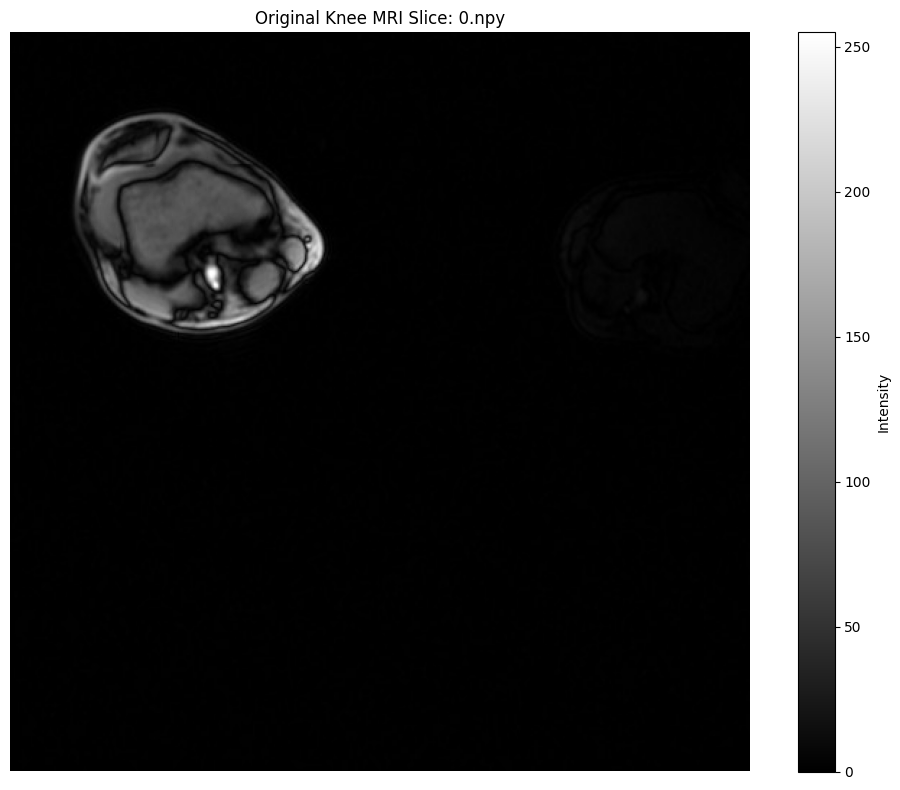


Note: Notice the low contrast in this medical image - perfect for CLAHE.

Image statistics:
Mean: 5.3, Std: 19.7
Min: 0, Max: 255


In [6]:
# --- Setup: Load knee MRI slice from DALI_extra ---
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob

# Path to DALI_extra MRI data
# The DALI_EXTRA_PATH should point to your DALI_extra repository
dali_extra_path = os.environ.get("DALI_EXTRA_PATH")

if dali_extra_path and os.path.exists(dali_extra_path):
    # Path to knee MRI 2D slices (nested in STU00001/SER00001/ subdirectories)
    mri_base_path = os.path.join(
        dali_extra_path, "db/3D/MRI/Knee/npy_2d_slices"
    )

    if os.path.exists(mri_base_path):
        # Find .npy files in nested subdirectories (e.g., STU00001/SER00001/*.npy)
        npy_pattern = os.path.join(mri_base_path, "STU00001/SER00001/*.npy")
        npy_files = sorted(glob.glob(npy_pattern))

        if npy_files:
            print(f"Loading knee MRI slice from DALI_extra...")
            print(f"Found {len(npy_files)} MRI slices in STU00001/SER00001/")

            # Load the first MRI slice (or you can choose a different index)
            mri_data = np.load(npy_files[0])

            print(f"MRI slice loaded: {os.path.basename(npy_files[0])}")
            print(f"Original shape: {mri_data.shape}, dtype: {mri_data.dtype}")

            # Normalize to uint8 if needed
            if mri_data.dtype != np.uint8:
                # Normalize to 0-255 range
                mri_min, mri_max = mri_data.min(), mri_data.max()
                if mri_max > mri_min:
                    mri_data = (
                        (mri_data - mri_min) / (mri_max - mri_min) * 255
                    ).astype(np.uint8)
                else:
                    mri_data = np.zeros_like(mri_data, dtype=np.uint8)
                print(
                    f"Normalized to uint8: range [{mri_data.min()}, {mri_data.max()}]"
                )

            # Ensure it has channel dimension (H, W, 1) for DALI compatibility
            if len(mri_data.shape) == 2:
                image = np.expand_dims(mri_data, axis=-1)
            else:
                image = mri_data

            print(f"Final shape for processing: {image.shape}")

            # Display the original MRI slice
            plt.figure(figsize=(10, 8))
            plt.imshow(image.squeeze(), cmap="gray", vmin=0, vmax=255)
            plt.title(
                f"Original Knee MRI Slice: {os.path.basename(npy_files[0])}"
            )
            plt.colorbar(label="Intensity")
            plt.axis("off")
            plt.tight_layout()
            plt.show()

            print(
                "\nNote: Notice the low contrast in this medical image - perfect for CLAHE."
            )

        else:
            print(f"Error: No .npy files found in {npy_pattern}")
            raise FileNotFoundError(f"No MRI data found at {npy_pattern}")
    else:
        print(f"Error: MRI base path not found: {mri_base_path}")
        raise FileNotFoundError(f"MRI base path not found: {mri_base_path}")
else:
    print(
        "Error: DALI_EXTRA_PATH environment variable not set or path doesn't exist"
    )
    print("Please set it to your DALI_extra repository path:")
    print("export DALI_EXTRA_PATH=/path/to/DALI_extra")
    raise EnvironmentError("DALI_EXTRA_PATH not properly configured")

print(f"\nImage statistics:")
print(f"Mean: {image.mean():.1f}, Std: {image.std():.1f}")
print(f"Min: {image.min()}, Max: {image.max()}")

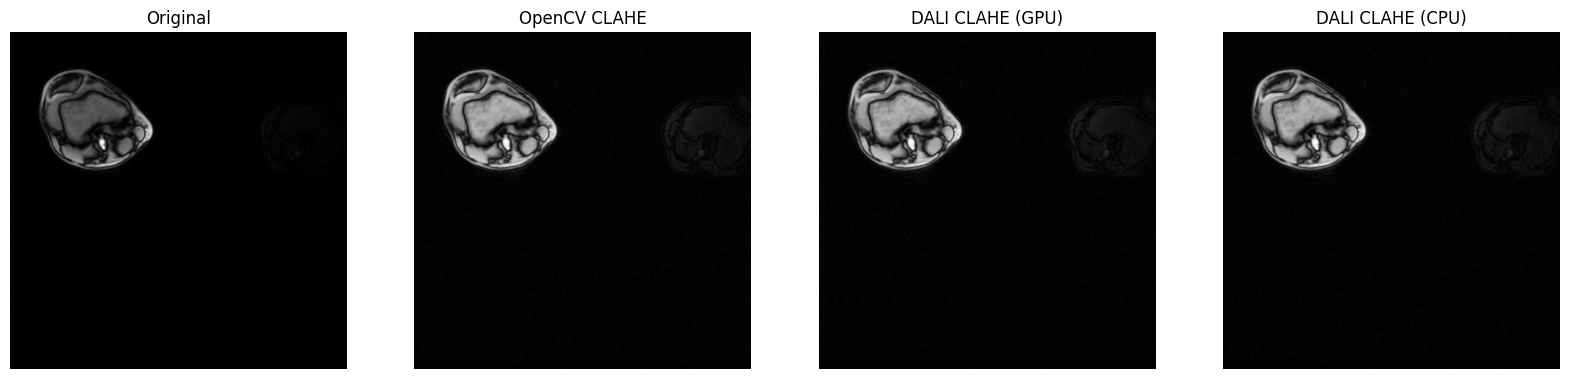


Implementation Comparison Metrics:
OpenCV vs DALI GPU:  MSE = 0.0000, MAE = 0.0000
OpenCV vs DALI CPU:  MSE = 0.0000, MAE = 0.0000
DALI GPU vs CPU:     MSE = 0.0000, MAE = 0.0000

Note: Lower values indicate closer agreement between implementations.


In [7]:
# --- CLAHE Processing: OpenCV and DALI ---
import nvidia.dali.fn as fn
import nvidia.dali.types as types
from nvidia.dali.pipeline import Pipeline


def apply_opencv_clahe(
    image, tiles_x=8, tiles_y=8, clip_limit=2.0, luma_only=True
):
    clahe = cv2.createCLAHE(
        clipLimit=float(clip_limit), tileGridSize=(tiles_x, tiles_y)
    )

    # Handle grayscale images (shape: H x W x 1 or H x W)
    if len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 1):
        # For grayscale, just apply CLAHE directly
        img_2d = image.squeeze() if len(image.shape) == 3 else image
        result = clahe.apply(img_2d)
        # Return with same shape as input
        if len(image.shape) == 3:
            result = np.expand_dims(result, axis=-1)
    # Handle RGB images (shape: H x W x 3)
    elif len(image.shape) == 3 and image.shape[2] == 3:
        if luma_only:
            lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
            lab[:, :, 0] = clahe.apply(lab[:, :, 0])
            result = cv2.cvtColor(lab, cv2.COLOR_Lab2RGB)
        else:
            result = np.zeros_like(image)
            for i in range(3):
                result[:, :, i] = clahe.apply(image[:, :, i])
    else:
        raise ValueError(f"Unsupported image shape: {image.shape}")

    return result


class MemoryPipeline(Pipeline):
    def __init__(
        self, image_array, tiles_x=8, tiles_y=8, clip_limit=2.0, device="gpu"
    ):
        super().__init__(batch_size=1, num_threads=1, device_id=0)
        self.image_array = image_array
        self.tiles_x = tiles_x
        self.tiles_y = tiles_y
        self.clip_limit = clip_limit
        self.device = device

    def define_graph(self):
        images = fn.external_source(
            source=lambda: [self.image_array],
            device="cpu",
            dtype=types.DALIDataType.UINT8,
            ndim=3,
        )
        if self.device == "gpu":
            images_processed = images.gpu()
        else:
            images_processed = images
        clahe_result = fn.clahe(
            images_processed,
            tiles_x=self.tiles_x,
            tiles_y=self.tiles_y,
            clip_limit=float(self.clip_limit),
            luma_only=False,  # For grayscale, luma_only should be False
            device=self.device,
        )
        return clahe_result


# Parameters
tiles_x, tiles_y, clip_limit = 8, 8, 2.0

# OpenCV CLAHE
opencv_result = apply_opencv_clahe(image, tiles_x, tiles_y, clip_limit)

# DALI CLAHE GPU
pipe_gpu = MemoryPipeline(image, tiles_x, tiles_y, clip_limit, "gpu")
pipe_gpu.build()
dali_gpu_result = pipe_gpu.run()[0].as_cpu().as_array()[0]

# DALI CLAHE CPU
pipe_cpu = MemoryPipeline(image, tiles_x, tiles_y, clip_limit, "cpu")
pipe_cpu.build()
dali_cpu_result = pipe_cpu.run()[0].as_cpu().as_array()[0]


# Calculate MSE and MAE between implementations
def calculate_metrics(img1, img2):
    """Calculate MSE and MAE between two images."""
    mse = np.mean((img1.astype(float) - img2.astype(float)) ** 2)
    mae = np.mean(np.abs(img1.astype(float) - img2.astype(float)))
    return mse, mae


# Flatten images for comparison
opencv_flat = opencv_result.squeeze()
dali_gpu_flat = dali_gpu_result.squeeze()
dali_cpu_flat = dali_cpu_result.squeeze()

# Calculate metrics
mse_ocv_gpu, mae_ocv_gpu = calculate_metrics(opencv_flat, dali_gpu_flat)
mse_ocv_cpu, mae_ocv_cpu = calculate_metrics(opencv_flat, dali_cpu_flat)
mse_gpu_cpu, mae_gpu_cpu = calculate_metrics(dali_gpu_flat, dali_cpu_flat)

# Show results
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(image.squeeze(), cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")
axes[1].imshow(opencv_result.squeeze(), cmap="gray")
axes[1].set_title("OpenCV CLAHE")
axes[1].axis("off")
axes[2].imshow(dali_gpu_result.squeeze(), cmap="gray")
axes[2].set_title("DALI CLAHE (GPU)")
axes[2].axis("off")
axes[3].imshow(dali_cpu_result.squeeze(), cmap="gray")
axes[3].set_title("DALI CLAHE (CPU)")
axes[3].axis("off")
plt.show()

# Print comparison metrics
print("\nImplementation Comparison Metrics:")
print("=" * 60)
print(f"OpenCV vs DALI GPU:  MSE = {mse_ocv_gpu:.4f}, MAE = {mae_ocv_gpu:.4f}")
print(f"OpenCV vs DALI CPU:  MSE = {mse_ocv_cpu:.4f}, MAE = {mae_ocv_cpu:.4f}")
print(f"DALI GPU vs CPU:     MSE = {mse_gpu_cpu:.4f}, MAE = {mae_gpu_cpu:.4f}")
print("\nNote: Lower values indicate closer agreement between implementations.")

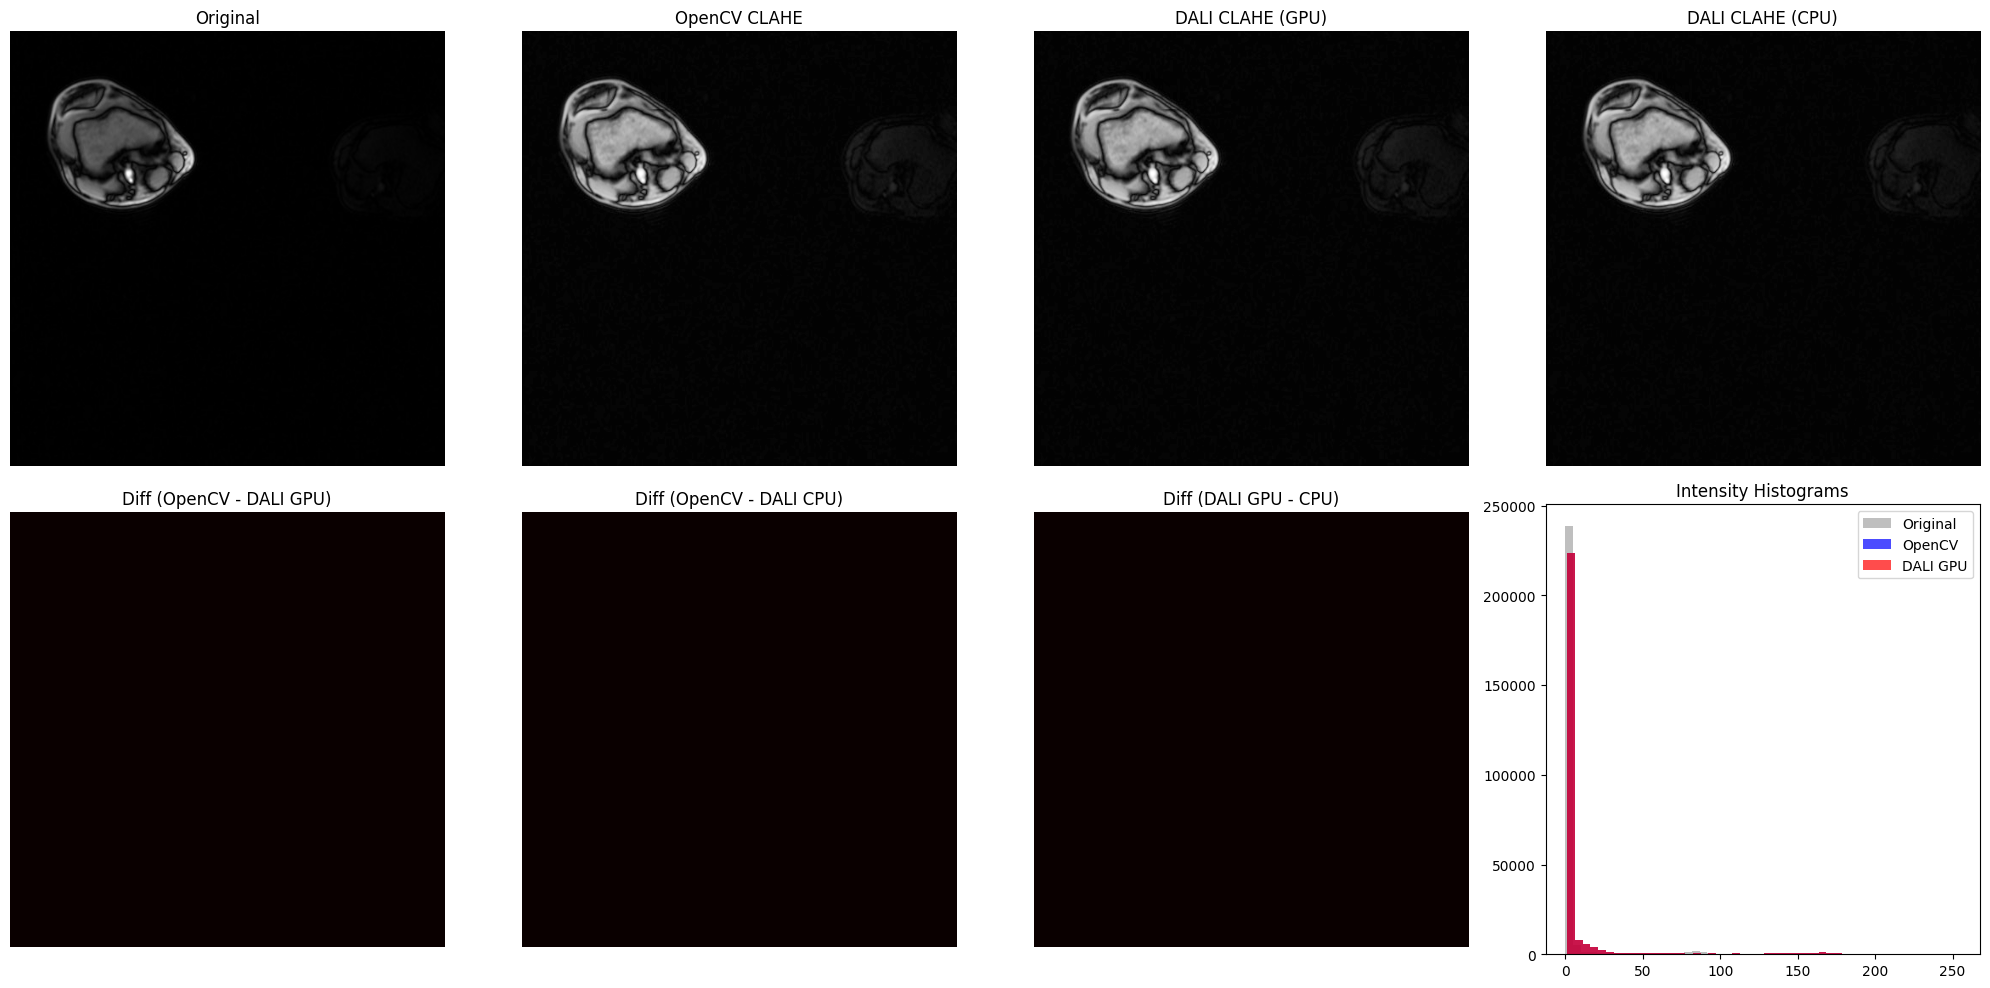

In [8]:
# --- Difference Maps and Luminance Histograms ---
def get_luminance(img):
    """Extract luminance from image. For grayscale, just return the image."""
    if len(img.shape) == 2:
        return img
    elif len(img.shape) == 3 and img.shape[2] == 1:
        return img.squeeze()
    else:
        # For RGB images, convert to YUV and extract Y channel
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:, :, 0]


# Calculate differences
diff_opencv_dali_gpu = np.abs(
    opencv_result.astype(float) - dali_gpu_result.astype(float)
)
diff_opencv_dali_cpu = np.abs(
    opencv_result.astype(float) - dali_cpu_result.astype(float)
)
diff_dali_gpu_cpu = np.abs(
    dali_gpu_result.astype(float) - dali_cpu_result.astype(float)
)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Top row: images
axes[0, 0].imshow(image.squeeze(), cmap="gray")
axes[0, 0].set_title("Original")
axes[0, 0].axis("off")
axes[0, 1].imshow(opencv_result.squeeze(), cmap="gray")
axes[0, 1].set_title("OpenCV CLAHE")
axes[0, 1].axis("off")
axes[0, 2].imshow(dali_gpu_result.squeeze(), cmap="gray")
axes[0, 2].set_title("DALI CLAHE (GPU)")
axes[0, 2].axis("off")
axes[0, 3].imshow(dali_cpu_result.squeeze(), cmap="gray")
axes[0, 3].set_title("DALI CLAHE (CPU)")
axes[0, 3].axis("off")

# Bottom row: difference maps
# For grayscale images, no need to average across channels
diff_opencv_gpu_2d = diff_opencv_dali_gpu.squeeze()
diff_opencv_cpu_2d = diff_opencv_dali_cpu.squeeze()
diff_gpu_cpu_2d = diff_dali_gpu_cpu.squeeze()

axes[1, 0].imshow(diff_opencv_gpu_2d, cmap="hot", vmin=0, vmax=50)
axes[1, 0].set_title("Diff (OpenCV - DALI GPU)")
axes[1, 0].axis("off")
axes[1, 1].imshow(diff_opencv_cpu_2d, cmap="hot", vmin=0, vmax=50)
axes[1, 1].set_title("Diff (OpenCV - DALI CPU)")
axes[1, 1].axis("off")
axes[1, 2].imshow(diff_gpu_cpu_2d, cmap="hot", vmin=0, vmax=50)
axes[1, 2].set_title("Diff (DALI GPU - CPU)")
axes[1, 2].axis("off")

# Intensity histograms
orig_lum = get_luminance(image)
opencv_lum = get_luminance(opencv_result)
dali_gpu_lum = get_luminance(dali_gpu_result)

axes[1, 3].hist(
    orig_lum.ravel(), bins=50, alpha=0.5, color="gray", label="Original"
)
axes[1, 3].hist(
    opencv_lum.ravel(), bins=50, alpha=0.7, color="blue", label="OpenCV"
)
axes[1, 3].hist(
    dali_gpu_lum.ravel(), bins=50, alpha=0.7, color="red", label="DALI GPU"
)
axes[1, 3].set_title("Intensity Histograms")
axes[1, 3].legend()

plt.tight_layout()
plt.show()

## Batch Processing MRI Slices with DALI Numpy Reader
Let's demonstrate a more realistic medical imaging workflow: processing **multiple MRI slices in batch** using DALI's numpy reader. This showcases DALI's strength in efficient data loading and GPU-accelerated processing.

> **Try it yourself:** This cell processes multiple MRI slices simultaneously, demonstrating the power of batched CLAHE processing.

Processing knee MRI slices with DALI...
Found 5 slices in STU00001/SER00001/
Path: /home/exthymic/DALI_extra/db/3D/MRI/Knee/npy_2d_slices/STU00001/SER00001

Running batch CLAHE on 4 MRI slices...


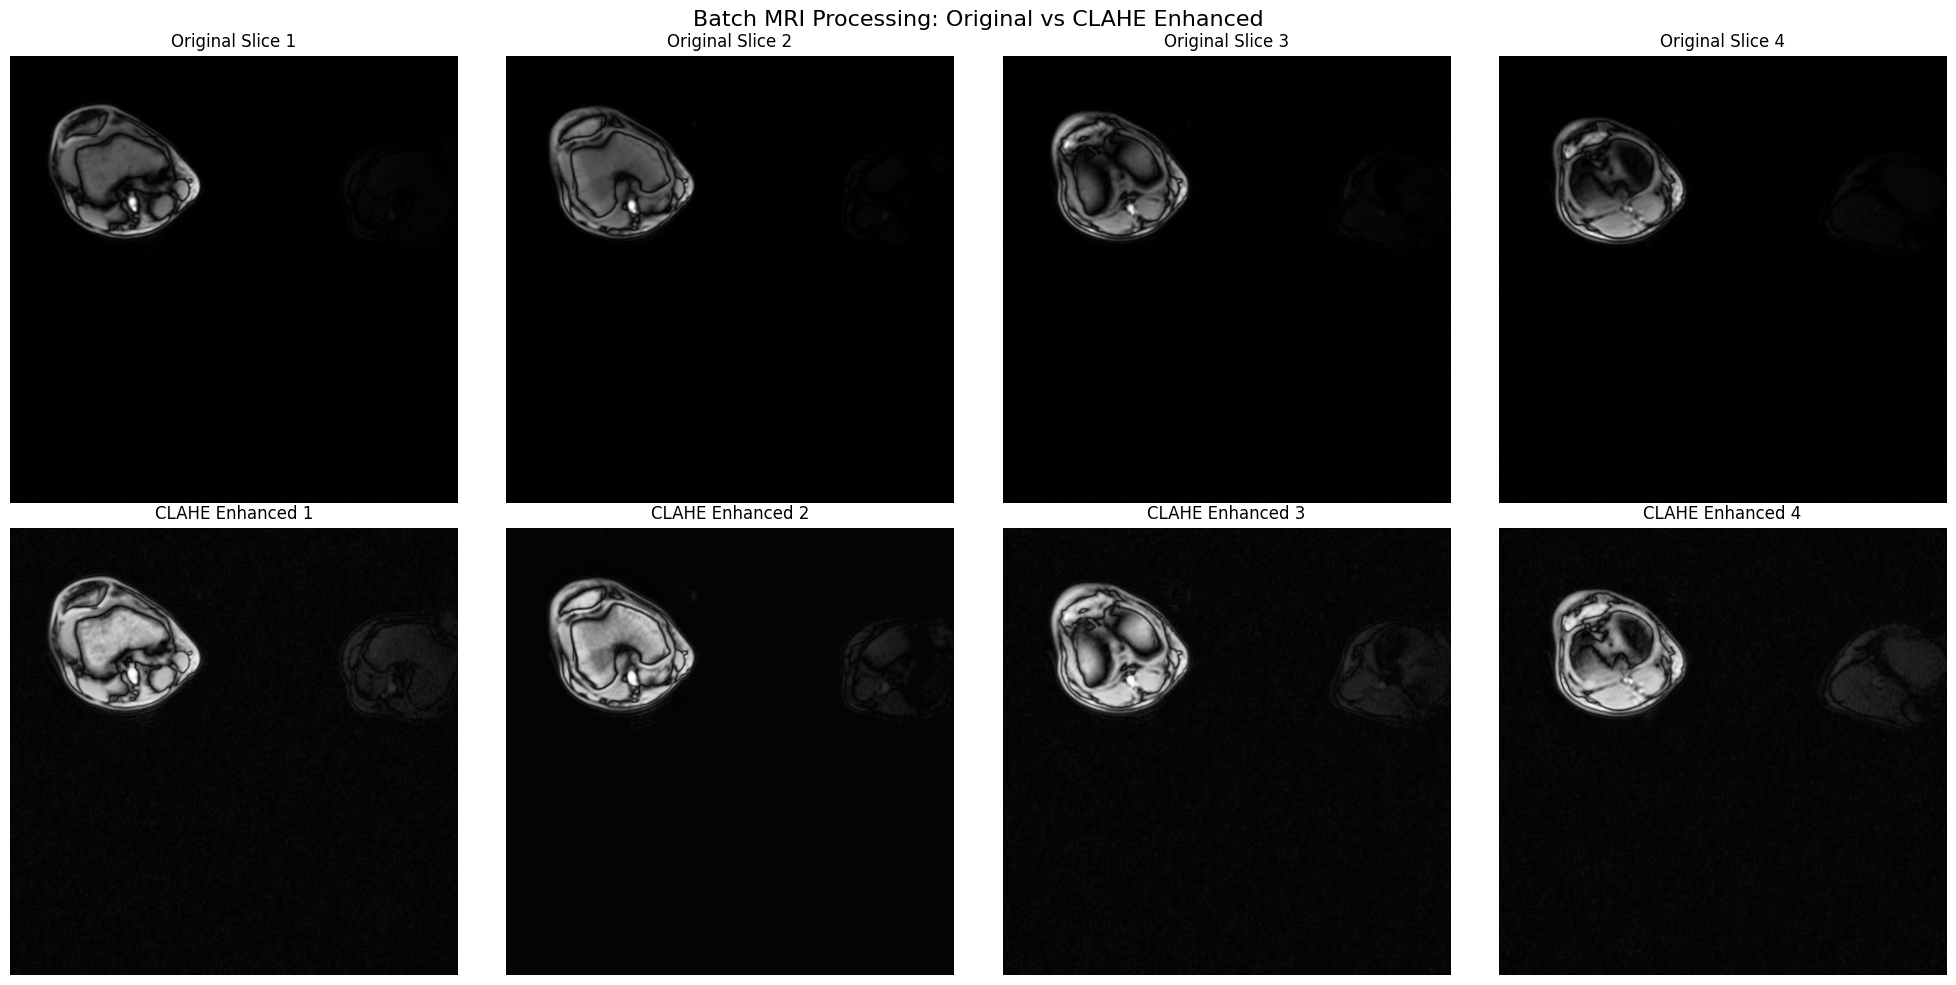


Contrast Improvement Analysis:
Slice 1:
  Original - Mean: 5.3, Std: 19.7
  Enhanced - Mean: 14.6, Std: 33.3
  Contrast improvement: 1.69x

Slice 2:
  Original - Mean: 5.1, Std: 20.1
  Enhanced - Mean: 12.7, Std: 33.0
  Contrast improvement: 1.64x

Slice 3:
  Original - Mean: 4.8, Std: 19.2
  Enhanced - Mean: 13.6, Std: 31.7
  Contrast improvement: 1.65x

Slice 4:
  Original - Mean: 4.7, Std: 19.6
  Enhanced - Mean: 13.1, Std: 30.3
  Contrast improvement: 1.54x

Batch processing complete!
Note: CLAHE reveals subtle tissue structures in the MRI slices.


In [9]:
# --- Batch MRI Processing with DALI Numpy Reader ---
import nvidia.dali.fn as fn
import nvidia.dali.types as types
from nvidia.dali.pipeline import Pipeline


def create_mri_clahe_pipeline(
    mri_data_path, batch_size=4, tiles_x=8, tiles_y=8, clip_limit=2.0
):
    """
    Create a DALI pipeline that reads MRI .npy files and applies CLAHE.

    Args:
        mri_data_path: Path to directory containing .npy files
        batch_size: Number of slices to process per batch
        tiles_x, tiles_y: CLAHE tile grid parameters
        clip_limit: CLAHE contrast limiting parameter

    Returns:
        DALI pipeline for batch MRI processing
    """

    @dali.pipeline_def(batch_size=batch_size, num_threads=2, device_id=0)
    def mri_processing_pipeline():
        # Read .npy files using DALI's numpy reader
        # This efficiently loads numpy arrays directly into DALI pipeline
        mri_slices = fn.readers.numpy(
            file_root=mri_data_path,
            file_filter="*.npy",
            device="cpu",
            random_shuffle=False,
            pad_last_batch=True,
        )

        # Normalize to uint8 if needed (most MRI data comes as float)
        # Check data type and normalize to 0-255 range
        mri_slices = fn.cast(mri_slices, dtype=types.FLOAT)

        # Normalize to [0, 1] range first
        min_val = fn.reductions.min(mri_slices)
        max_val = fn.reductions.max(mri_slices)
        mri_normalized = (mri_slices - min_val) / (max_val - min_val + 1e-8)

        # Scale to [0, 255] and convert to uint8
        mri_uint8 = fn.cast(mri_normalized * 255, dtype=types.UINT8)

        # Add channel dimension to make it HWC format (required by CLAHE)
        # For 2D data (H, W), add axis at position 2 to get (H, W, 1)
        # First assign HW layout, then expand to add channel dimension
        mri_uint8 = fn.reshape(mri_uint8, layout="HW")
        mri_uint8 = fn.expand_dims(mri_uint8, axes=2, new_axis_names="C")

        # Move to GPU for CLAHE processing
        mri_gpu = mri_uint8.gpu()

        # Apply CLAHE on GPU
        clahe_output = fn.clahe(
            mri_gpu,
            tiles_x=tiles_x,
            tiles_y=tiles_y,
            clip_limit=clip_limit,
            luma_only=False,  # For grayscale, luma_only should be False
        )

        return mri_uint8, clahe_output

    return mri_processing_pipeline()


# Check if we have MRI data available
dali_extra_path = os.environ.get("DALI_EXTRA_PATH")

if dali_extra_path and os.path.exists(dali_extra_path):
    # MRI data is in nested subdirectories: STU00001/SER00001/*.npy
    mri_path = os.path.join(
        dali_extra_path, "db/3D/MRI/Knee/npy_2d_slices/STU00001/SER00001"
    )

    if os.path.exists(mri_path):
        npy_files = glob.glob(os.path.join(mri_path, "*.npy"))

        if len(npy_files) >= 4:
            print(f"Processing knee MRI slices with DALI...")
            print(f"Found {len(npy_files)} slices in STU00001/SER00001/")
            print(f"Path: {mri_path}")

            # Create and build pipeline
            batch_size = min(4, len(npy_files))
            mri_pipe = create_mri_clahe_pipeline(
                mri_data_path=mri_path,
                batch_size=batch_size,
                tiles_x=8,
                tiles_y=8,
                clip_limit=3.0,  # Higher clip limit for medical imaging
            )
            mri_pipe.build()

            # Run pipeline
            print(f"\nRunning batch CLAHE on {batch_size} MRI slices...")
            outputs = mri_pipe.run()
            original_batch, clahe_batch = outputs

            # Convert to numpy for visualization
            original_np = [
                np.array(original_batch[i].as_cpu()).squeeze()
                for i in range(batch_size)
            ]
            clahe_np = [
                np.array(clahe_batch[i].as_cpu()).squeeze()
                for i in range(batch_size)
            ]

            # Visualize results in a grid
            fig, axes = plt.subplots(2, batch_size, figsize=(20, 10))

            for i in range(batch_size):
                # Original MRI
                axes[0, i].imshow(original_np[i], cmap="gray", vmin=0, vmax=255)
                axes[0, i].set_title(f"Original Slice {i+1}")
                axes[0, i].axis("off")

                # CLAHE enhanced MRI
                axes[1, i].imshow(clahe_np[i], cmap="gray", vmin=0, vmax=255)
                axes[1, i].set_title(f"CLAHE Enhanced {i+1}")
                axes[1, i].axis("off")

            plt.suptitle(
                "Batch MRI Processing: Original vs CLAHE Enhanced",
                fontsize=16,
                y=0.98,
            )
            plt.tight_layout()
            plt.show()

            # Compute contrast improvement statistics
            print("\nContrast Improvement Analysis:")
            print("=" * 60)
            for i in range(batch_size):
                orig_std = np.std(original_np[i])
                clahe_std = np.std(clahe_np[i])
                improvement = clahe_std / orig_std if orig_std > 0 else 1.0

                print(f"Slice {i+1}:")
                print(
                    f"  Original - Mean: {original_np[i].mean():.1f}, Std: {orig_std:.1f}"
                )
                print(
                    f"  Enhanced - Mean: {clahe_np[i].mean():.1f}, Std: {clahe_std:.1f}"
                )
                print(f"  Contrast improvement: {improvement:.2f}x")
                print()

            print("Batch processing complete!")
            print(
                "Note: CLAHE reveals subtle tissue structures in the MRI slices."
            )

        else:
            print(f"Warning: Not enough MRI files found ({len(npy_files)} < 4)")
            print("Need at least 4 files for batch demonstration")
    else:
        print(f"Warning: MRI path not found: {mri_path}")
        print(
            "Expected path: $DALI_EXTRA_PATH/db/3D/MRI/Knee/npy_2d_slices/STU00001/SER00001/"
        )
else:
    print("Warning: DALI_EXTRA_PATH not set or invalid")
    print("To use this feature, set the environment variable:")
    print("export DALI_EXTRA_PATH=/path/to/DALI_extra")
    print("\nThe knee MRI data should be at:")
    print("$DALI_EXTRA_PATH/db/3D/MRI/Knee/npy_2d_slices/STU00001/SER00001/")

### Understanding CLAHE's Effect on Medical Images
Let's analyze how CLAHE transforms the intensity distribution of MRI data, which helps understand why it's so effective for medical imaging.

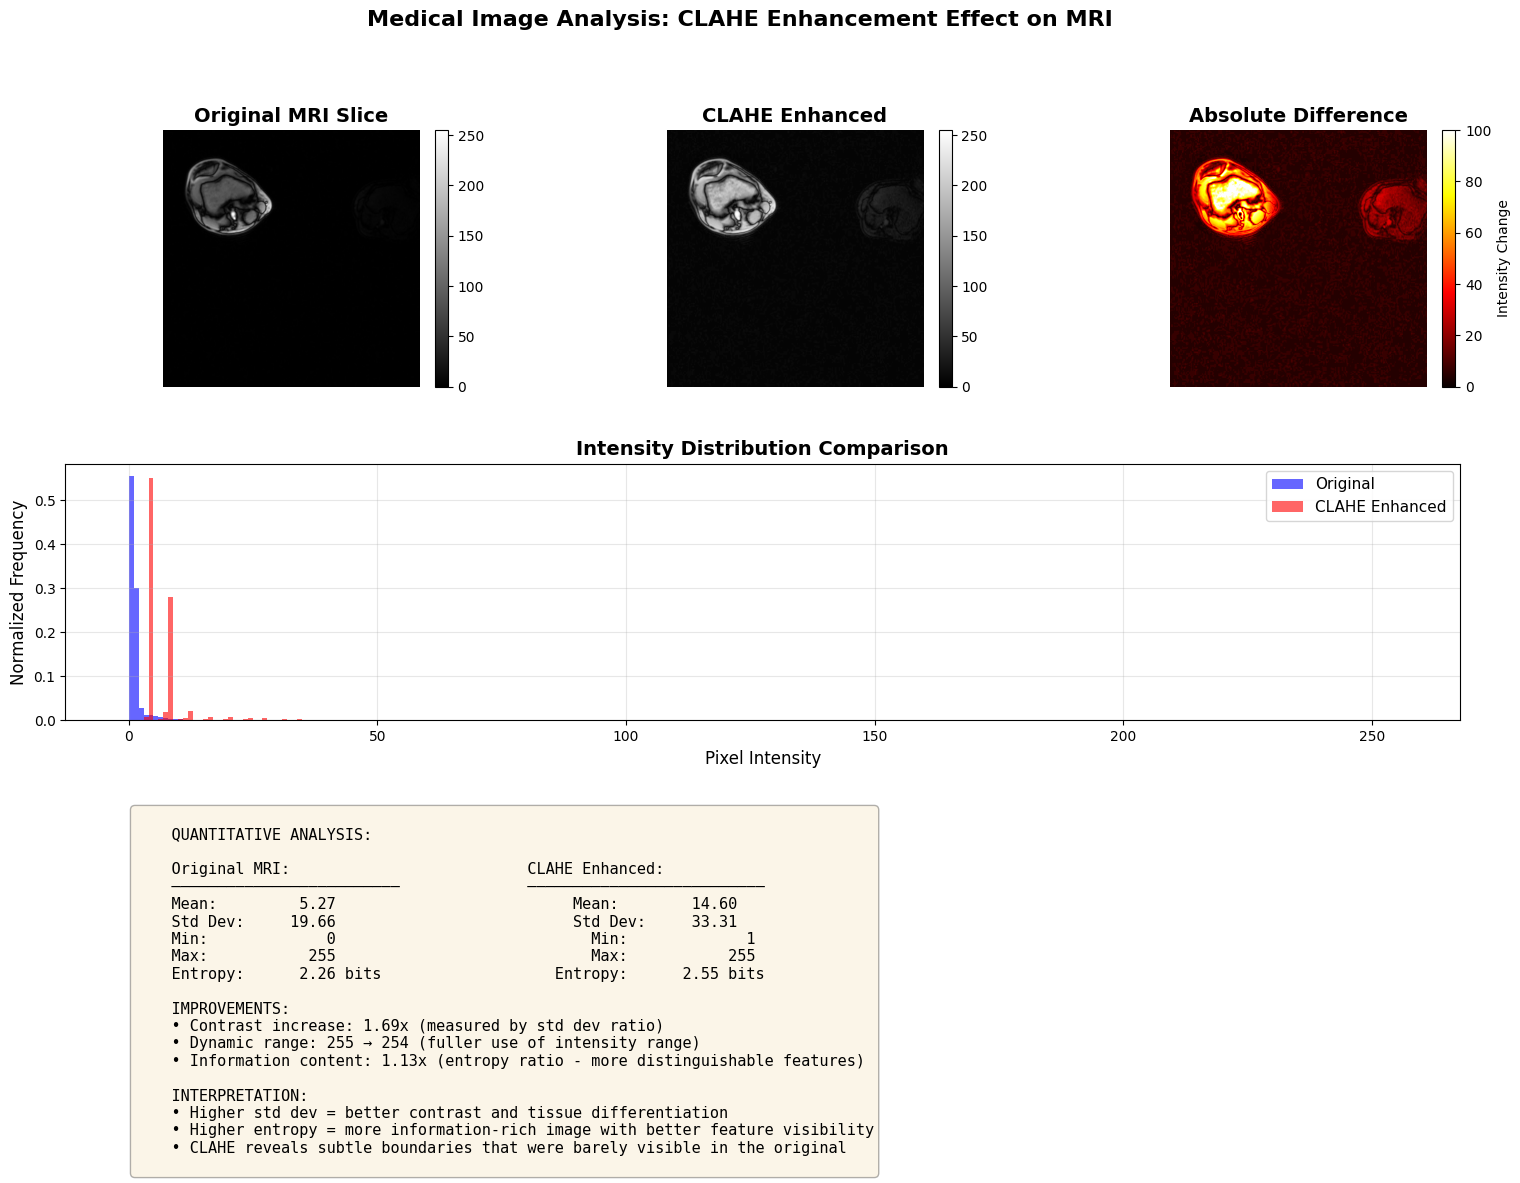

Analysis complete!

Key Insight for Medical Imaging:
   CLAHE adaptively enhances local contrast in each tissue region,
   making it ideal for MRI where different tissues have overlapping
   intensity ranges but important local boundaries.


In [10]:
# --- Histogram Analysis for Medical Imaging ---

# Check if we have MRI results from previous cell
if (
    "original_np" in locals()
    and "clahe_np" in locals()
    and len(original_np) > 0
):
    # Analyze the first slice in detail
    orig_slice = original_np[0]
    clahe_slice = clahe_np[0]

    # Create comprehensive visualization
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # Row 1: Images
    ax1 = fig.add_subplot(gs[0, 0])
    im1 = ax1.imshow(orig_slice, cmap="gray", vmin=0, vmax=255)
    ax1.set_title("Original MRI Slice", fontsize=14, fontweight="bold")
    ax1.axis("off")
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

    ax2 = fig.add_subplot(gs[0, 1])
    im2 = ax2.imshow(clahe_slice, cmap="gray", vmin=0, vmax=255)
    ax2.set_title("CLAHE Enhanced", fontsize=14, fontweight="bold")
    ax2.axis("off")
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

    ax3 = fig.add_subplot(gs[0, 2])
    diff = np.abs(clahe_slice.astype(float) - orig_slice.astype(float))
    im3 = ax3.imshow(diff, cmap="hot", vmin=0, vmax=100)
    ax3.set_title("Absolute Difference", fontsize=14, fontweight="bold")
    ax3.axis("off")
    plt.colorbar(
        im3, ax=ax3, fraction=0.046, pad=0.04, label="Intensity Change"
    )

    # Row 2: Histograms
    ax4 = fig.add_subplot(gs[1, :])
    ax4.hist(
        orig_slice.ravel(),
        bins=256,
        alpha=0.6,
        color="blue",
        label="Original",
        range=(0, 255),
        density=True,
    )
    ax4.hist(
        clahe_slice.ravel(),
        bins=256,
        alpha=0.6,
        color="red",
        label="CLAHE Enhanced",
        range=(0, 255),
        density=True,
    )
    ax4.set_xlabel("Pixel Intensity", fontsize=12)
    ax4.set_ylabel("Normalized Frequency", fontsize=12)
    ax4.set_title(
        "Intensity Distribution Comparison", fontsize=14, fontweight="bold"
    )
    ax4.legend(fontsize=11)
    ax4.grid(True, alpha=0.3)

    # Row 3: Statistics
    ax5 = fig.add_subplot(gs[2, :])
    ax5.axis("off")

    # Calculate statistics
    orig_mean = orig_slice.mean()
    orig_std = orig_slice.std()
    orig_min = orig_slice.min()
    orig_max = orig_slice.max()

    clahe_mean = clahe_slice.mean()
    clahe_std = clahe_slice.std()
    clahe_min = clahe_slice.min()
    clahe_max = clahe_slice.max()

    # Calculate entropy (measure of information content)
    orig_hist, _ = np.histogram(
        orig_slice.ravel(), bins=256, range=(0, 255), density=True
    )
    clahe_hist, _ = np.histogram(
        clahe_slice.ravel(), bins=256, range=(0, 255), density=True
    )

    orig_entropy = -np.sum(orig_hist * np.log2(orig_hist + 1e-10))
    clahe_entropy = -np.sum(clahe_hist * np.log2(clahe_hist + 1e-10))

    stats_text = f"""
    QUANTITATIVE ANALYSIS:
    
    Original MRI:                          CLAHE Enhanced:
    ─────────────────────────              ──────────────────────────
    Mean:       {orig_mean:6.2f}                          Mean:       {clahe_mean:6.2f}
    Std Dev:    {orig_std:6.2f}                          Std Dev:    {clahe_std:6.2f}
    Min:        {orig_min:6.0f}                            Min:        {clahe_min:6.0f}
    Max:        {orig_max:6.0f}                            Max:        {clahe_max:6.0f}
    Entropy:    {orig_entropy:6.2f} bits                   Entropy:    {clahe_entropy:6.2f} bits
    
    IMPROVEMENTS:
    • Contrast increase: {(clahe_std/orig_std):.2f}x (measured by std dev ratio)
    • Dynamic range: {orig_max-orig_min:.0f} → {clahe_max-clahe_min:.0f} (fuller use of intensity range)
    • Information content: {(clahe_entropy/orig_entropy):.2f}x (entropy ratio - more distinguishable features)
    
    INTERPRETATION:
    • Higher std dev = better contrast and tissue differentiation
    • Higher entropy = more information-rich image with better feature visibility
    • CLAHE reveals subtle boundaries that were barely visible in the original
    """

    ax5.text(
        0.05,
        0.95,
        stats_text,
        transform=ax5.transAxes,
        fontsize=11,
        verticalalignment="top",
        fontfamily="monospace",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.3),
    )

    plt.suptitle(
        "Medical Image Analysis: CLAHE Enhancement Effect on MRI",
        fontsize=16,
        fontweight="bold",
        y=0.98,
    )
    plt.show()

    print("Analysis complete!")
    print("\nKey Insight for Medical Imaging:")
    print("   CLAHE adaptively enhances local contrast in each tissue region,")
    print("   making it ideal for MRI where different tissues have overlapping")
    print("   intensity ranges but important local boundaries.")

elif "image" in locals():
    # Fall back to single-image analysis from section 8
    print("Analyzing single MRI slice from section 8...")

    # Apply CLAHE to the single image for comparison
    opencv_clahe = apply_opencv_clahe(
        image, tiles_x=8, tiles_y=8, clip_limit=3.0
    )

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(image.squeeze(), cmap="gray", vmin=0, vmax=255)
    axes[0].set_title("Original", fontsize=14)
    axes[0].axis("off")

    axes[1].imshow(opencv_clahe.squeeze(), cmap="gray", vmin=0, vmax=255)
    axes[1].set_title("CLAHE Enhanced", fontsize=14)
    axes[1].axis("off")

    axes[2].hist(
        image.ravel(), bins=50, alpha=0.6, color="blue", label="Original"
    )
    axes[2].hist(
        opencv_clahe.ravel(), bins=50, alpha=0.6, color="red", label="CLAHE"
    )
    axes[2].set_title("Intensity Distributions", fontsize=14)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

else:
    print("No MRI data available for histogram analysis")
    print("   Please run the previous cells to load MRI data first.")

## CLAHE on Color Images: WebP Example
Now let's demonstrate CLAHE on a **color photograph** using a WebP image from DALI_extra. 

**Important:** DALI's GPU CLAHE only supports `luma_only=True` (the default), which processes the luminance channel in LAB color space. This is the recommended approach for RGB images as it:
- Preserves natural color relationships
- Produces visually superior results
- Matches OpenCV's LAB-based CLAHE behavior
- Runs efficiently on GPU

If you need per-channel RGB processing (`luma_only=False`), you must use the CPU operator.

Make sure you use RGB channel order for DALI CLAHE. OpenCV's default is BGR channel order.

The cat image (`db/single/webp/lossy/cat-3591348_640.webp`) is perfect for demonstrating:
- **RGB processing**: Standard web image format (3-channel RGB)
- **Natural scenes**: Real-world photography with varying lighting conditions
- **Luminance-based enhancement**: How CLAHE improves contrast while preserving colors

In [11]:
# Configuration for color image CLAHE processing
# Set USE_LUMA_ONLY to control how CLAHE processes color images:
#
# True (default): Process only luminance in LAB color space
#        - Preserves color relationships better
#        - More natural-looking results for color images
#        - Supported on both GPU and CPU
#        - GPU ONLY supports this mode
#
# False: Process each RGB channel independently
#        - Enhances contrast in each channel separately
#        - Can introduce color shifts
#        - ONLY works with DALI CPU operator (not supported on GPU)
#
USE_LUMA_ONLY = (
    True  # Default and GPU-only mode. Set to False for per-channel (CPU only)
)

### Understanding Implementation Differences

**GPU vs CPU CLAHE Support:**

The GPU implementation only supports `luma_only=True` (the default), which processes the luminance channel in LAB color space. This is the recommended mode for RGB images as it preserves color relationships.

**When to use each setting:**
- **`USE_LUMA_ONLY = True`** (default, GPU-supported): Processes luminance in LAB color space
  - ✅ **GPU-accelerated (fast!)**
  - ✅ Works on both GPU and CPU
  - ✅ Preserves color relationships better
  - ✅ More natural-looking results for photographs
  - ✅ OpenCV and DALI produce nearly identical results
  
- **`USE_LUMA_ONLY = False`**: Processes RGB channels independently
  - ⚠️ **CPU ONLY** - GPU does not support this mode
  - ✅ Good for specific use cases requiring per-channel enhancement
  - ⚠️ May introduce color artifacts
  - ⚠️ Slower (CPU-only)

**Why the difference?**
The GPU implementation prioritizes the most common and visually superior mode (`luma_only=True`) for optimal performance. Per-channel RGB processing would require extracting and processing each channel separately, which is less efficient and produces inferior results for most applications.

> **Try it yourself**: Change `USE_LUMA_ONLY` above and re-run the next cell to see the difference! Note that setting it to False will use CPU processing.

Loading cat image from DALI_extra...
Path: /home/exthymic/DALI_extra/db/single/webp/lossy/cat-3591348_640.webp
Image loaded: shape=(427, 640, 3), dtype=uint8
Value range: [0, 255]

Applying OpenCV CLAHE (luma_only=True)...
Applying DALI GPU CLAHE (luma_only=True)...


[/opt/dali/dali/operators/image/clahe/clahe_op.cc:92] CLAHE GPU backend does not support per-channel mode (luma_only=False). RGB images will be processed in luminance-only mode. Use CPU backend for per-channel processing.


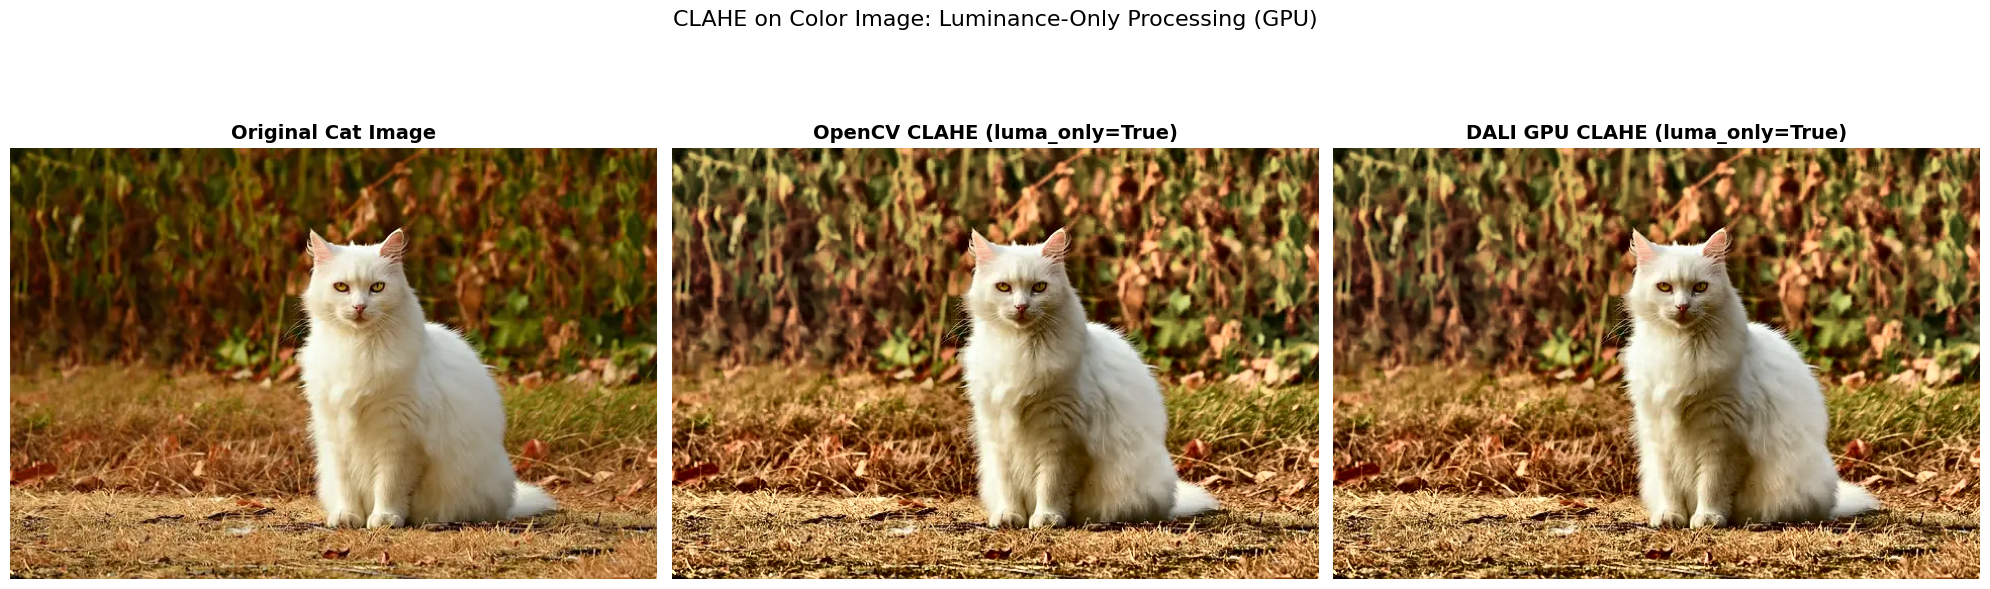

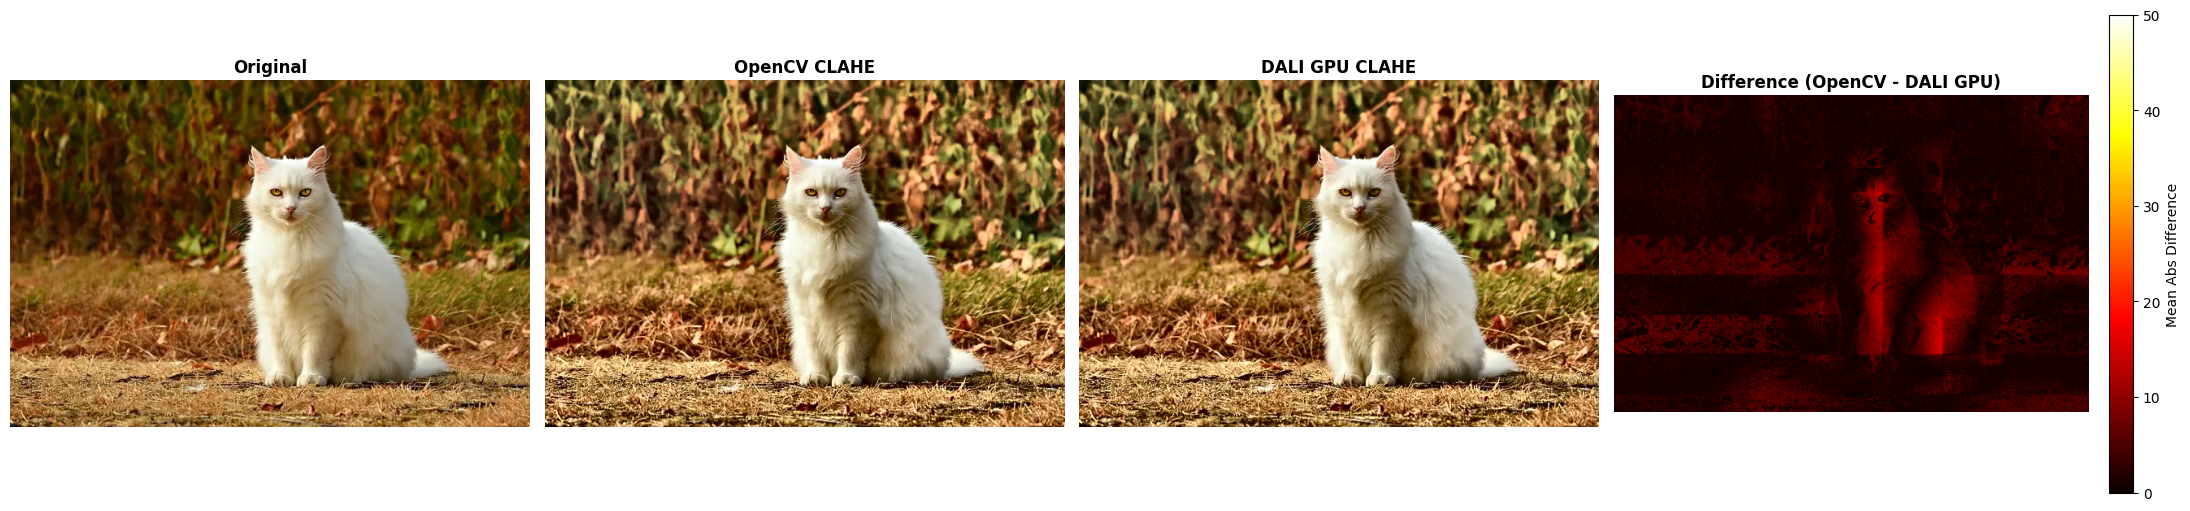


COLOR IMAGE CLAHE COMPARISON (luma_only=True)
OpenCV vs DALI GPU:  MSE = 10.1286, MAE = 2.2590

Image Statistics:
Original       - Mean: 88.1, Std: 63.6
OpenCV         - Mean: 103.3, Std: 67.4
DALI GPU    - Mean: 102.9, Std: 67.2

Contrast Improvement:
OpenCV:        1.06x
DALI GPU    1.06x

Note: With luma_only=True, CLAHE processes only the luminance channel in LAB color space.
This preserves color relationships and produces more natural-looking results.
GPU DALI supports this mode and provides fast acceleration.
Both OpenCV and DALI use similar LAB-based processing for luma_only=True.


In [12]:
# --- CLAHE on Color Images: Cat WebP Example ---
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import nvidia.dali.fn as fn
import nvidia.dali.types as types
from nvidia.dali.pipeline import Pipeline

# Load cat image from DALI_extra
dali_extra_path = os.environ.get("DALI_EXTRA_PATH")

if dali_extra_path and os.path.exists(dali_extra_path):
    cat_image_path = os.path.join(
        dali_extra_path, "db/single/webp/lossy/cat-3591348_640.webp"
    )

    if os.path.exists(cat_image_path):
        print(f"Loading cat image from DALI_extra...")
        print(f"Path: {cat_image_path}")

        # Load the cat image using OpenCV (it will be in BGR format)
        cat_bgr = cv2.imread(cat_image_path)

        if cat_bgr is not None:
            # Convert BGR to RGB for proper display
            cat_rgb = cv2.cvtColor(cat_bgr, cv2.COLOR_BGR2RGB)

            print(f"Image loaded: shape={cat_rgb.shape}, dtype={cat_rgb.dtype}")
            print(f"Value range: [{cat_rgb.min()}, {cat_rgb.max()}]")

            # Determine device based on USE_LUMA_ONLY setting
            # GPU supports luma_only=True, but NOT luma_only=False
            device_to_use = "gpu" if USE_LUMA_ONLY else "cpu"

            # Apply OpenCV CLAHE
            print(f"\nApplying OpenCV CLAHE (luma_only={USE_LUMA_ONLY})...")
            opencv_clahe_rgb = apply_opencv_clahe(
                cat_rgb,
                tiles_x=8,
                tiles_y=8,
                clip_limit=2.0,
                luma_only=USE_LUMA_ONLY,
            )

            # Apply DALI CLAHE
            print(
                f"Applying DALI {device_to_use.upper()} CLAHE (luma_only={USE_LUMA_ONLY})..."
            )
            pipe_rgb = MemoryPipeline(
                cat_rgb,
                tiles_x=8,
                tiles_y=8,
                clip_limit=2.0,
                device=device_to_use,
            )
            pipe_rgb.build()
            outputs_rgb = pipe_rgb.run()
            dali_clahe_rgb = outputs_rgb[0].as_cpu().as_array()[0]

            # Calculate metrics
            mse_ocv_dali, mae_ocv_dali = calculate_metrics(
                opencv_clahe_rgb, dali_clahe_rgb
            )

            # Display results
            fig, axes = plt.subplots(1, 3, figsize=(20, 7))

            axes[0].imshow(cat_rgb)
            axes[0].set_title(
                "Original Cat Image", fontsize=14, fontweight="bold"
            )
            axes[0].axis("off")

            axes[1].imshow(opencv_clahe_rgb)
            axes[1].set_title(
                f"OpenCV CLAHE (luma_only={USE_LUMA_ONLY})",
                fontsize=14,
                fontweight="bold",
            )
            axes[1].axis("off")

            axes[2].imshow(dali_clahe_rgb)
            axes[2].set_title(
                f"DALI {device_to_use.upper()} CLAHE (luma_only={USE_LUMA_ONLY})",
                fontsize=14,
                fontweight="bold",
            )
            axes[2].axis("off")

            processing_type = (
                "Luminance-Only Processing (GPU)"
                if USE_LUMA_ONLY
                else "Per-Channel Processing (CPU)"
            )
            plt.suptitle(
                f"CLAHE on Color Image: {processing_type}", fontsize=16, y=0.98
            )
            plt.tight_layout()
            plt.show()

            # Show difference map
            fig, axes = plt.subplots(1, 4, figsize=(22, 6))

            axes[0].imshow(cat_rgb)
            axes[0].set_title("Original", fontsize=12, fontweight="bold")
            axes[0].axis("off")

            axes[1].imshow(opencv_clahe_rgb)
            axes[1].set_title("OpenCV CLAHE", fontsize=12, fontweight="bold")
            axes[1].axis("off")

            axes[2].imshow(dali_clahe_rgb)
            axes[2].set_title(
                f"DALI {device_to_use.upper()} CLAHE",
                fontsize=12,
                fontweight="bold",
            )
            axes[2].axis("off")

            # Difference map between OpenCV and DALI
            diff_rgb = np.abs(
                opencv_clahe_rgb.astype(float) - dali_clahe_rgb.astype(float)
            )
            diff_rgb_display = np.mean(
                diff_rgb, axis=2
            )  # Average across RGB channels for visualization
            im = axes[3].imshow(diff_rgb_display, cmap="hot", vmin=0, vmax=50)
            axes[3].set_title(
                f"Difference (OpenCV - DALI {device_to_use.upper()})",
                fontsize=12,
                fontweight="bold",
            )
            axes[3].axis("off")
            plt.colorbar(
                im,
                ax=axes[3],
                fraction=0.046,
                pad=0.04,
                label="Mean Abs Difference",
            )

            plt.tight_layout()
            plt.show()

            # Print comparison metrics
            print("\n" + "=" * 60)
            print(f"COLOR IMAGE CLAHE COMPARISON (luma_only={USE_LUMA_ONLY})")
            print("=" * 60)
            print(
                f"OpenCV vs DALI {device_to_use.upper()}:  MSE = {mse_ocv_dali:.4f}, MAE = {mae_ocv_dali:.4f}"
            )
            print("\nImage Statistics:")
            print(
                f"Original       - Mean: {cat_rgb.mean():.1f}, Std: {cat_rgb.std():.1f}"
            )
            print(
                f"OpenCV         - Mean: {opencv_clahe_rgb.mean():.1f}, Std: {opencv_clahe_rgb.std():.1f}"
            )
            print(
                f"DALI {device_to_use.upper():6} - Mean: {dali_clahe_rgb.mean():.1f}, Std: {dali_clahe_rgb.std():.1f}"
            )

            contrast_orig = cat_rgb.std()
            contrast_opencv = opencv_clahe_rgb.std()
            contrast_dali = dali_clahe_rgb.std()

            print(f"\nContrast Improvement:")
            print(f"OpenCV:        {contrast_opencv/contrast_orig:.2f}x")
            print(
                f"DALI {device_to_use.upper():6} {contrast_dali/contrast_orig:.2f}x"
            )

            if USE_LUMA_ONLY:
                print(
                    "\nNote: With luma_only=True, CLAHE processes only the luminance channel in LAB color space."
                )
                print(
                    "This preserves color relationships and produces more natural-looking results."
                )
                print(
                    "GPU DALI supports this mode and provides fast acceleration."
                )
                print(
                    "Both OpenCV and DALI use similar LAB-based processing for luma_only=True."
                )
            else:
                print(
                    "\nNote: With luma_only=False, CLAHE is applied to each RGB channel independently."
                )
                print(
                    "This can enhance contrast but may introduce color shifts compared to luma_only=True."
                )
                print(
                    "This mode requires CPU processing as GPU does not support per-channel RGB mode."
                )

        else:
            print(f"Error: Failed to load image from {cat_image_path}")
    else:
        print(f"Error: Cat image not found at {cat_image_path}")
        print(
            "Expected path: $DALI_EXTRA_PATH/db/single/webp/lossy/cat-3591348_640.webp"
        )
else:
    print(
        "Error: DALI_EXTRA_PATH environment variable not set or path doesn't exist"
    )
    print("Please set it to your DALI_extra repository path:")
    print("export DALI_EXTRA_PATH=/path/to/DALI_extra")